# Introduction 

The notebook walks us through a typical workflow for solving data science competitions at sites like Kaggle. There are several excellent notebooks to study data science competition entries. I am super excited to share my first kernel with the Kaggle community. As I go on in this journey and learn new topics, I will incorporate them with each new updates. So, check for them and please leave a comment if you have any suggestions to make this kernel better. Going back to the topics of this kernel, I will do more in-depth visualizations to explain the data, and the machine learning classifiers will be used to predict passenger survival status.

The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew.



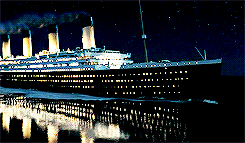

### Part 1: Importing Necessary Libraries and datasets

In [468]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [469]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
df_gender = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

### Part 2: Exploratory Data Analysis

In [470]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())


In [471]:
 check_df(df_train)

##################### Shape #####################
(891, 12)
##################### Types #####################
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
##################### Head #####################
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex    Age  SibSp  \
0                            Braund, Mr. Owen Harris    male 22.000      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1   
2                             Heikkinen, Miss. Laina  female 26.000      0   
3       Futrelle, Mrs.

In [472]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [473]:
print(df_train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


#### Variable

In [475]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

num_cols = [col for col in num_cols if col not in "PassengerId"]

df_train.shape

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


(891, 12)

#### ANALYSIS OF CATEGORY VARIABLES

In [476]:
def cat_summary(dataframe,col_name,plot = False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts(),
    "Ratio":100*dataframe[col_name].value_counts() / len(dataframe)}))

    print("##########################################")
    if plot:
       sns.countplot(x=dataframe[col_name], data= dataframe)
       plt.show()

cat_summary(df_train,"Sex")

        Sex  Ratio
Sex               
male    577 64.759
female  314 35.241
##########################################


#### ANALYSIS OF NUMERICAL VARIABLES

count   714.000
mean     29.699
std      14.526
min       0.420
5%        4.000
10%      14.000
20%      19.000
30%      22.000
40%      25.000
50%      28.000
60%      31.800
70%      36.000
80%      41.000
90%      50.000
95%      56.000
99%      65.870
max      80.000
Name: Age, dtype: float64


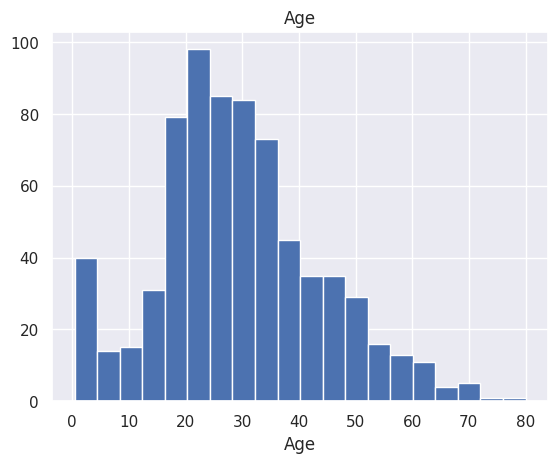

count   891.000
mean     32.204
std      49.693
min       0.000
5%        7.225
10%       7.550
20%       7.854
30%       8.050
40%      10.500
50%      14.454
60%      21.679
70%      27.000
80%      39.688
90%      77.958
95%     112.079
99%     249.006
max     512.329
Name: Fare, dtype: float64


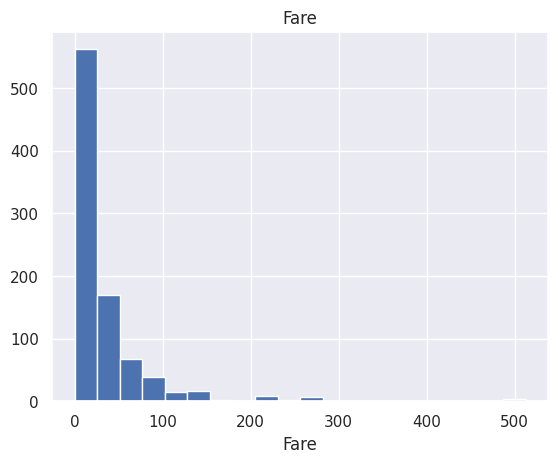

In [477]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


for col in num_cols:
    num_summary(df_train, col, plot=True)

#### ANALYSIS OF NUMERICAL VARIABLES ACCORDING TO TARGET

In [478]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df_train, "Survived", col)

            Age
Survived       
0        30.626
1        28.344


           Fare
Survived       
0        22.118
1        48.395




#### ANALYSIS OF Categorical VARIABLES ACCORDING TO TARGET

In [479]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df_train, "Survived", col)

        TARGET_MEAN
Sex                
female        0.742
male          0.189


          TARGET_MEAN
Embarked             
C               0.554
Q               0.390
S               0.337


          TARGET_MEAN
Survived             
0               0.000
1               1.000


        TARGET_MEAN
Pclass             
1             0.630
2             0.473
3             0.242


       TARGET_MEAN
SibSp             
0            0.345
1            0.536
2            0.464
3            0.250
4            0.167
5            0.000
8            0.000


       TARGET_MEAN
Parch             
0            0.344
1            0.551
2            0.500
3            0.600
4            0.000
5            0.200
6            0.000




#### MISSING VALUE ANALYSIS

In [480]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df_train, na_name=True)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


In [481]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df_train, "Survived", na_columns)

             TARGET_MEAN  Count
Age_NA_FLAG                    
0                  0.406    714
1                  0.294    177


               TARGET_MEAN  Count
Cabin_NA_FLAG                    
0                    0.667    204
1                    0.300    687


                  TARGET_MEAN  Count
Embarked_NA_FLAG                    
0                       0.382    889
1                       1.000      2




### Outlier ANALYSIS

In [482]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

####  Encoding (Label Encoding, One-Hot Encoding, Rare Encoding)

In [483]:
# Label Encoding & Binary Encoding

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df_train.columns if df_train[col].dtype not in [int, float]
               and df_train[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df_train, col)



In [484]:
# One-Hot Encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df_train.columns if 10 >= df_train[col].nunique() > 2]


one_hot_encoder(df_train, ohe_cols).head()

,PassengerId,Survived,Name,Sex,Age,Ticket,Fare,Cabin,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,22.000,A/5 21171,7.250,NaN,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000,PC 17599,71.283,C85,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,1,"Heikkinen, Miss. Laina",0,26.000,STON/O2. 3101282,7.925,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000,113803,53.100,C123,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,5,0,"Allen, Mr. William Henry",1,35.000,373450,8.050,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [ ]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


#############################################
# 3. Rare encoder'ın yazılması.
#############################################

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [485]:
df_train.columns = [col.upper() for col in df_train.columns]
df_train.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.000,0,0,373450,8.050,NaN,S


In [486]:
df_test.columns = [col.upper() for col in df_test.columns]
df_test.head()

,PASSENGERID,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


## Part 3: Feature Engineering 

In [487]:
# Cabin bool
df_train["NEW_CABIN_BOOL"] = df_train["CABIN"].notnull().astype('int')
# Name count
df_train["NEW_NAME_COUNT"] = df_train["NAME"].str.len()
# name word count
df_train["NEW_NAME_WORD_COUNT"] = df_train["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df_train["NEW_NAME_DR"] = df_train["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df_train['NEW_TITLE'] = df_train.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df_train["NEW_FAMILY_SIZE"] = df_train["SIBSP"] + df_train["PARCH"] + 1
# age_pclass
df_train["NEW_AGE_PCLASS"] = df_train["AGE"] * df_train["PCLASS"]
# is alone
df_train.loc[((df_train['SIBSP'] + df_train['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df_train.loc[((df_train['SIBSP'] + df_train['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df_train.loc[(df_train['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df_train.loc[(df_train['AGE'] >= 18) & (df_train['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df_train.loc[(df_train['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'


df_train.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,2,38.000,NO,mature
2,3,1,3,"Heikkinen, Miss. Laina",0,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,35.000,NO,mature
4,5,0,3,"Allen, Mr. William Henry",1,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,105.000,YES,mature


In [488]:
df_train.isnull().sum()

PASSENGERID          0
SURVIVED             0
PCLASS               0
NAME                 0
SEX                  0
                  ... 
NEW_TITLE            0
NEW_FAMILY_SIZE      0
NEW_AGE_PCLASS     177
NEW_IS_ALONE         0
NEW_AGE_CAT        177
Length: 21, dtype: int64

In [489]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

num_cols = [col for col in num_cols if "PASSENGERID" not in col]

Observations: 891
Variables: 21
cat_cols: 13
num_cols: 5
cat_but_car: 3
num_but_cat: 9


In [490]:
# Cabin bool
df_test["NEW_CABIN_BOOL"] = df_test["CABIN"].notnull().astype('int')
# Name count
df_test["NEW_NAME_COUNT"] = df_test["NAME"].str.len()
# name word count
df_test["NEW_NAME_WORD_COUNT"] = df_test["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df_test["NEW_NAME_DR"] = df_test["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df_test['NEW_TITLE'] = df_test.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df_test["NEW_FAMILY_SIZE"] = df_test["SIBSP"] + df_test["PARCH"] + 1
# age_pclass
df_test["NEW_AGE_PCLASS"] = df_test["AGE"] * df_test["PCLASS"]
# is alone
df_test.loc[((df_test['SIBSP'] + df_test['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df_test.loc[((df_test['SIBSP'] + df_test['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"
# age level
df_test.loc[(df_test['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df_test.loc[(df_test['AGE'] >= 18) & (df_test['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df_test.loc[(df_test['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'



In [491]:
df_test.head()

,PASSENGERID,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q,0,16,3,0,Mr,1,103.500,YES,mature
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S,0,32,5,0,Mrs,2,141.000,NO,mature
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q,0,25,4,0,Mr,1,124.000,YES,senior
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S,0,16,3,0,Mr,1,81.000,YES,mature
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S,0,44,6,0,Mrs,3,66.000,NO,mature


In [492]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_test)

num_cols = [col for col in num_cols if "PASSENGERID" not in col]

Observations: 418
Variables: 20
cat_cols: 12
num_cols: 5
cat_but_car: 3
num_but_cat: 7


In [493]:
for col in num_cols:
    print(col, check_outlier(df_train, col))

for col in num_cols:
    replace_with_thresholds(df_train, col)

for col in num_cols:
    print(col, check_outlier(df_train, col))

AGE False
FARE True
NEW_NAME_COUNT False
NEW_AGE_PCLASS False
AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [494]:
for col in num_cols:
    print(col, check_outlier(df_test, col))

for col in num_cols:
    replace_with_thresholds(df_test, col)

for col in num_cols:
    print(col, check_outlier(df_test, col))

AGE False
FARE True
NEW_NAME_COUNT False
NEW_AGE_PCLASS False
AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [495]:
missing_values_table(df_train)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [496]:
missing_values_table(df_test)

                n_miss  ratio
CABIN              327 78.230
AGE                 86 20.570
NEW_AGE_PCLASS      86 20.570
NEW_AGE_CAT         86 20.570
FARE                 1  0.240


In [497]:
df_train.drop("CABIN", inplace=True, axis=1)

remove_cols = ["TICKET", "NAME"]
df_train.drop(remove_cols, inplace=True, axis=1)

df_train.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT
0,1,0,3,1,22.000,1,0,7.250,S,0,23.000,4,0,Mr,2,66.000,NO,mature
1,2,1,1,0,38.000,1,0,71.283,C,1,51.000,7,0,Mrs,2,38.000,NO,mature
2,3,1,3,0,26.000,0,0,7.925,S,0,22.000,3,0,Miss,1,78.000,YES,mature
3,4,1,1,0,35.000,1,0,53.100,S,1,44.000,7,0,Mrs,2,35.000,NO,mature
4,5,0,3,1,35.000,0,0,8.050,S,0,24.000,4,0,Mr,1,105.000,YES,mature


In [498]:
df_test.drop("CABIN", inplace=True, axis=1)
df_test['FARE'].fillna(df_test['FARE'].dropna().median(), inplace=True)

remove_cols = ["TICKET", "NAME"]
df_test.drop(remove_cols, inplace=True, axis=1)

df_test.head()

,PASSENGERID,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT
0,892,3,male,34.500,0,0,7.829,Q,0,16,3,0,Mr,1,103.500,YES,mature
1,893,3,female,47.000,1,0,7.000,S,0,32,5,0,Mrs,2,141.000,NO,mature
2,894,2,male,62.000,0,0,9.688,Q,0,25,4,0,Mr,1,124.000,YES,senior
3,895,3,male,27.000,0,0,8.662,S,0,16,3,0,Mr,1,81.000,YES,mature
4,896,3,female,22.000,1,1,12.287,S,0,44,6,0,Mrs,3,66.000,NO,mature


In [499]:
df_train["AGE"] = df_train["AGE"].fillna(df_train.groupby("NEW_TITLE")["AGE"].transform("median"))


df_train["NEW_AGE_PCLASS"] = df_train["AGE"] * df_train["PCLASS"]

df_train.loc[(df_train['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df_train.loc[(df_train['AGE'] >= 18) & (df_train['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df_train.loc[(df_train['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'


df_train.isnull().sum()

PASSENGERID            0
SURVIVED               0
PCLASS                 0
SEX                    0
AGE                    0
SIBSP                  0
PARCH                  0
FARE                   0
EMBARKED               2
NEW_CABIN_BOOL         0
NEW_NAME_COUNT         0
NEW_NAME_WORD_COUNT    0
NEW_NAME_DR            0
NEW_TITLE              0
NEW_FAMILY_SIZE        0
NEW_AGE_PCLASS         0
NEW_IS_ALONE           0
NEW_AGE_CAT            0
dtype: int64

In [500]:
df_train.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()

PASSENGERID            0
SURVIVED               0
PCLASS                 0
SEX                    0
AGE                    0
SIBSP                  0
PARCH                  0
FARE                   0
EMBARKED               0
NEW_CABIN_BOOL         0
NEW_NAME_COUNT         0
NEW_NAME_WORD_COUNT    0
NEW_NAME_DR            0
NEW_TITLE              0
NEW_FAMILY_SIZE        0
NEW_AGE_PCLASS         0
NEW_IS_ALONE           0
NEW_AGE_CAT            0
dtype: int64

In [501]:
df_test["AGE"] = df_test["AGE"].fillna(df_train.groupby("NEW_TITLE")["AGE"].transform("median"))


df_test["NEW_AGE_PCLASS"] = df_test["AGE"] * df_test["PCLASS"]

df_test.loc[(df_test['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df_test.loc[(df_test['AGE'] >= 18) & (df_test['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df_test.loc[(df_test['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'




df_test.isnull().sum()

PASSENGERID            0
PCLASS                 0
SEX                    0
AGE                    0
SIBSP                  0
PARCH                  0
FARE                   0
EMBARKED               0
NEW_CABIN_BOOL         0
NEW_NAME_COUNT         0
NEW_NAME_WORD_COUNT    0
NEW_NAME_DR            0
NEW_TITLE              0
NEW_FAMILY_SIZE        0
NEW_AGE_PCLASS         0
NEW_IS_ALONE           0
NEW_AGE_CAT            0
dtype: int64

In [502]:
df_test.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0).isnull().sum()

PASSENGERID            0
PCLASS                 0
SEX                    0
AGE                    0
SIBSP                  0
PARCH                  0
FARE                   0
EMBARKED               0
NEW_CABIN_BOOL         0
NEW_NAME_COUNT         0
NEW_NAME_WORD_COUNT    0
NEW_NAME_DR            0
NEW_TITLE              0
NEW_FAMILY_SIZE        0
NEW_AGE_PCLASS         0
NEW_IS_ALONE           0
NEW_AGE_CAT            0
dtype: int64

In [503]:
binary_cols = [col for col in df_train.columns if df_train[col].dtype not in [int, float]
               and df_train[col].nunique() == 2]

for col in binary_cols:
    df_train = label_encoder(df_train, col)
    
df_train.head()
df_train.shape

(891, 18)

In [504]:
binary_cols = [col for col in df_test.columns if df_test[col].dtype not in [int, float]
               and df_test[col].nunique() == 2]

for col in binary_cols:
    df_test = label_encoder(df_test, col)
    
df_test.head()
df_test.shape

(418, 17)

In [505]:
df_train = rare_encoder(df_train, 0.01)
df_train.shape

(891, 18)

In [506]:
df_test = rare_encoder(df_test,0.01)
df_test.shape

(418, 17)

In [507]:
ohe_cols = [col for col in df_train.columns if 10 >= df_train[col].nunique() > 2]

df_train = one_hot_encoder(df_train, ohe_cols)

df_train.head()


,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young
0,1,0,1,22.000,7.250,0,23.000,0,66.000,0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
1,2,1,0,38.000,71.283,1,51.000,0,38.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
2,3,1,0,26.000,7.925,0,22.000,0,78.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.000,53.100,1,44.000,0,35.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
4,5,0,1,35.000,8.050,0,24.000,0,105.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [508]:
df_train.shape

(891, 47)

In [509]:
ohe_cols = [col for col in df_test.columns if 10 >= df_test[col].nunique() > 2]

df_test = one_hot_encoder(df_test, ohe_cols)

df_test.head()

,PASSENGERID,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,PARCH_9,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young
0,892,1,34.500,7.829,0,16,0,103.500,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,893,0,47.000,7.000,0,32,0,141.000,0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
2,894,1,62.000,9.688,0,25,0,124.000,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,895,1,27.000,8.662,0,16,0,81.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,896,0,22.000,12.287,0,44,0,66.000,0,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False


In [510]:
df_test.shape

(418, 46)

In [511]:
columns1 = set(df_train.columns)
columns2 = set(df_test.columns)

# Eşit olmayan veya fazla olan sütun adlarını bulalım
different_columns = columns1.symmetric_difference(columns2)

if different_columns:
    print("Eşit olmayan veya fazla olan sütun adları:")
    for column in different_columns:
        print(column)
else:
    print("Eşit olmayan veya fazla olan sütun adı yok.")
 


Eşit olmayan veya fazla olan sütun adları:
PARCH_9
SURVIVED
NEW_NAME_WORD_COUNT_14


In [512]:
result = [
"NEW_NAME_WORD_COUNT_14",

"PARCH_9"]

for column in result:
    if column in df_train.columns:
        df_train = df_train.drop(columns=[column])
    if column in df_test.columns:
        df_test = df_test.drop(columns=[column])

print("df_train_columns güncellenmiş hali:")
print(df_train.columns.values)

print("\ndf_test_columns güncellenmiş hali:")
print(df_test.columns.values)

df_train_columns güncellenmiş hali:
['PASSENGERID' 'SURVIVED' 'SEX' 'AGE' 'FARE' 'NEW_CABIN_BOOL'
 'NEW_NAME_COUNT' 'NEW_NAME_DR' 'NEW_AGE_PCLASS' 'NEW_IS_ALONE' 'PCLASS_2'
 'PCLASS_3' 'SIBSP_1' 'SIBSP_2' 'SIBSP_3' 'SIBSP_4' 'SIBSP_5' 'SIBSP_8'
 'PARCH_1' 'PARCH_2' 'PARCH_3' 'PARCH_4' 'PARCH_5' 'PARCH_6' 'EMBARKED_Q'
 'EMBARKED_S' 'NEW_NAME_WORD_COUNT_4' 'NEW_NAME_WORD_COUNT_5'
 'NEW_NAME_WORD_COUNT_6' 'NEW_NAME_WORD_COUNT_7' 'NEW_NAME_WORD_COUNT_8'
 'NEW_NAME_WORD_COUNT_9' 'NEW_TITLE_Miss' 'NEW_TITLE_Mr' 'NEW_TITLE_Mrs'
 'NEW_TITLE_Rare' 'NEW_FAMILY_SIZE_2' 'NEW_FAMILY_SIZE_3'
 'NEW_FAMILY_SIZE_4' 'NEW_FAMILY_SIZE_5' 'NEW_FAMILY_SIZE_6'
 'NEW_FAMILY_SIZE_7' 'NEW_FAMILY_SIZE_8' 'NEW_FAMILY_SIZE_11'
 'NEW_AGE_CAT_senior' 'NEW_AGE_CAT_young']

df_test_columns güncellenmiş hali:
['PASSENGERID' 'SEX' 'AGE' 'FARE' 'NEW_CABIN_BOOL' 'NEW_NAME_COUNT'
 'NEW_NAME_DR' 'NEW_AGE_PCLASS' 'NEW_IS_ALONE' 'PCLASS_2' 'PCLASS_3'
 'SIBSP_1' 'SIBSP_2' 'SIBSP_3' 'SIBSP_4' 'SIBSP_5' 'SIBSP_8' 'PARCH_1'
 'PAR

In [513]:
scaler = StandardScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

df_train[num_cols].head()



,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.557,-0.557,-0.427,0.063
1,0.649,0.920,2.591,-0.787
2,-0.256,-0.541,-0.535,0.427
3,0.423,0.501,1.836,-0.878
4,0.423,-0.538,-0.320,1.247


In [514]:
scaler = StandardScaler()
df_test[num_cols] = scaler.fit_transform(df_test[num_cols])

df_test[num_cols].head()


,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,0.362,-0.515,-1.153,1.395
1,1.326,-0.530,0.454,2.678
2,2.484,-0.480,-0.249,2.096
3,-0.217,-0.499,-1.153,0.625
4,-0.602,-0.431,1.658,0.112


In [515]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PASSENGERID            418 non-null    int64  
 1   SEX                    418 non-null    int64  
 2   AGE                    418 non-null    float64
 3   FARE                   418 non-null    float64
 4   NEW_CABIN_BOOL         418 non-null    int64  
 5   NEW_NAME_COUNT         418 non-null    float64
 6   NEW_NAME_DR            418 non-null    int64  
 7   NEW_AGE_PCLASS         418 non-null    float64
 8   NEW_IS_ALONE           418 non-null    int64  
 9   PCLASS_2               418 non-null    bool   
 10  PCLASS_3               418 non-null    bool   
 11  SIBSP_1                418 non-null    bool   
 12  SIBSP_2                418 non-null    bool   
 13  SIBSP_3                418 non-null    bool   
 14  SIBSP_4                418 non-null    bool   
 15  SIBSP_

In [516]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PASSENGERID            891 non-null    int64  
 1   SURVIVED               891 non-null    int64  
 2   SEX                    891 non-null    int64  
 3   AGE                    891 non-null    float64
 4   FARE                   891 non-null    float64
 5   NEW_CABIN_BOOL         891 non-null    int64  
 6   NEW_NAME_COUNT         891 non-null    float64
 7   NEW_NAME_DR            891 non-null    int64  
 8   NEW_AGE_PCLASS         891 non-null    float64
 9   NEW_IS_ALONE           891 non-null    int64  
 10  PCLASS_2               891 non-null    bool   
 11  PCLASS_3               891 non-null    bool   
 12  SIBSP_1                891 non-null    bool   
 13  SIBSP_2                891 non-null    bool   
 14  SIBSP_3                891 non-null    bool   
 15  SIBSP_

In [517]:
X_train = df_train.drop(["PASSENGERID", "SURVIVED"], axis=1)
y_train = df_train["SURVIVED"]
X_test  = df_test.drop("PASSENGERID",axis=1).copy()

X_train.shape, y_train.shape, X_test.shape

((891, 44), (891,), (418, 44))

In [519]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)

acc_log

83.95

In [518]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)

acc_svc

85.19

In [520]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

acc_knn

87.77

In [521]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)

acc_gaussian

42.99

In [522]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)

acc_perceptron

75.42

In [524]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

83.39

In [525]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

79.46

In [526]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

99.55

In [527]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

In [528]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,99.550
8,Decision Tree,99.550
1,KNN,87.770
0,Support Vector Machines,85.190
2,Logistic Regression,83.950
7,Linear SVC,83.390
6,Stochastic Gradient Decent,79.460
5,Perceptron,75.420
4,Naive Bayes,42.990


    Value                Feature
2   0.127                   FARE
6   0.125         NEW_AGE_PCLASS
4   0.123         NEW_NAME_COUNT
0   0.110                    SEX
1   0.092                    AGE
..    ...                    ...
20  0.001                PARCH_5
14  0.001                SIBSP_5
18  0.000                PARCH_3
21  0.000                PARCH_6
29  0.000  NEW_NAME_WORD_COUNT_9

[44 rows x 2 columns]


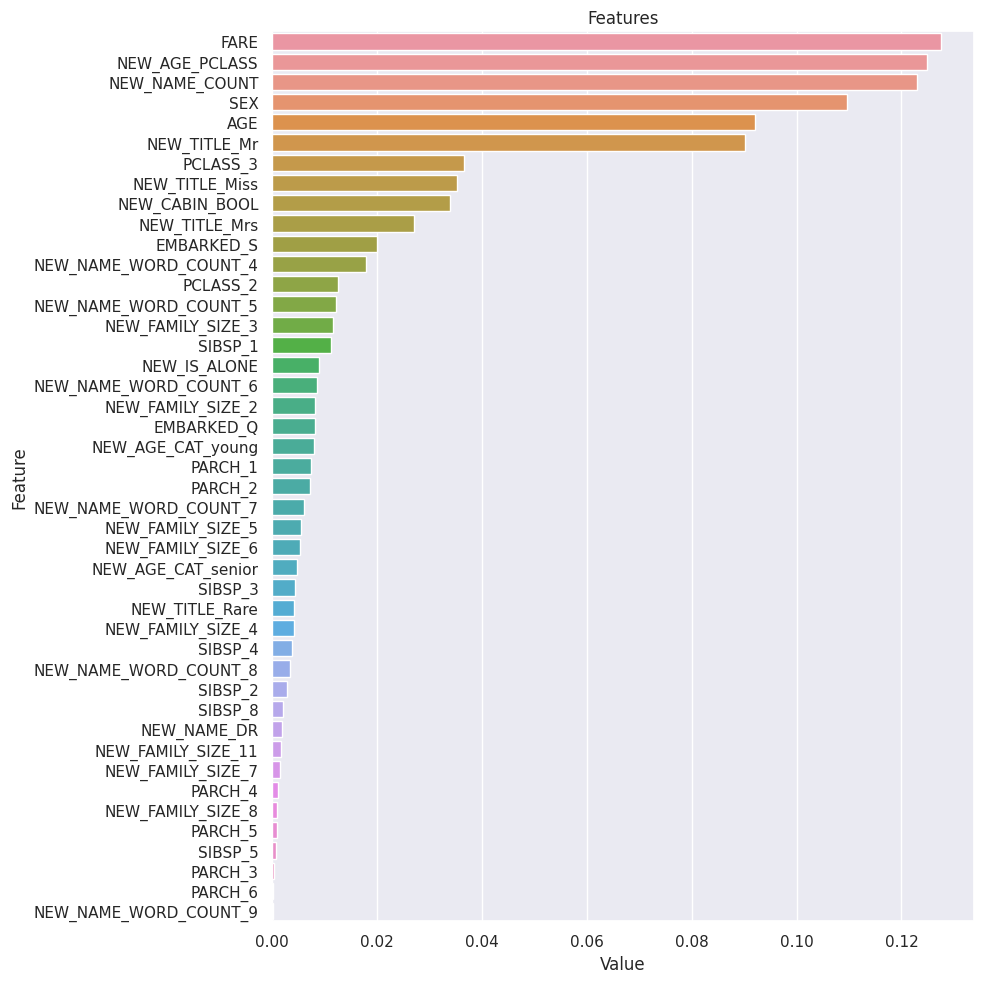

In [529]:
def plot_importance(model, features, num=len(X_train), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(random_forest, X_train)


In [530]:
output = pd.DataFrame({'PassengerId': df_test.PASSENGERID, 'Survived': predictions})

output.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!


In [531]:
output.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
